In [ ]:
'''What attributes can be used to predict hotel booking cancellation?'''

import pandas as pd

# load dataset
data = pd.read_csv('cleaned_hotel_booking.csv')

# inspect the data
# check if there are any NaN values in the dataset
if data.isnull().values.any():
    # find columns with NaN values
    nan_columns = data.columns[data.isnull().any()]
    print("Columns containing NaN values:")
    print(nan_columns)
    
    # count NaN values per column
    nan_count = data.isnull().sum()
    print("\nNumber of NaN values per column:")
    print(nan_count)
else:
    print("No NaN values in the dataset.")


Columns containing NaN values:
Index(['children', 'country'], dtype='object')

Number of NaN values per column:
hotel                               0
is_canceled                         0
lead_time                           0
arrival_date                        0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_day_of_month           0
arrival_date_week_number            0
stays_in_weekend_nights             0
stays_in_week_nights                0
stays_total_nights                  0
adults                              0
children                            4
babies                              0
meal                                0
country                           464
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
booking_changes                     0
deposit_type                        0
days_in_waitin

In [17]:
from sklearn.model_selection import train_test_split

# Step 1: Handle missing values
# fill missing children with 0 (assuming no children if NaN)
data['children'].fillna(0, inplace=True)

# fill missing countries with 'Unknown'
data['country'].fillna('Unknown', inplace=True)

# Step 2: Drop irrelevant columns
# 'arrival_date' can be replaced with its components (already present), so drop
data.drop(['arrival_date'], axis=1, inplace=True)

# drop the 'reservation_status' column because its values fully predict the cancellation status; if the status is "Check-Out," it guarantees the 
# reservation is not canceled; any other status implies the reservation is canceled.
data.drop(['reservation_status'], axis=1, inplace=True)
 
# Step 3: Encode categorical variables
# use one-hot encoder for multi-category columns
categorical_columns = [
    'hotel', 'arrival_date_month', 'meal', 'country',
    'market_segment', 'distribution_channel', 'deposit_type',
    'customer_type',
]
# apply one-hot encoding to these columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

# Step 4: Define features and target variable
X = data.drop(columns=['is_canceled', 'reservation_status_date'])
y = data['is_canceled']

# Step 5: Train-test split (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Step 6: Initialize and train the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(random_state=42, max_depth=4)
dt_classifier.fit(X_train, y_train)

print("Tree depth:", dt_classifier.get_depth())
print("Number of leaves:", dt_classifier.get_n_leaves())

### there are 207 total leaves with the tree depth of 10, that is probably too many; set max_depth to 5 instead

# Step 7: Evaluate the model on the test set
y_pred = dt_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

# display classification report and accuracy
classification_rep = classification_report(y_test, y_pred)
accuracy, classification_rep

# export the structure of the tree as text
tree_rules = export_text(dt_classifier, feature_names=list(X.columns))
print(tree_rules)

Tree depth: 4
Number of leaves: 14
|--- deposit_type_Non Refund <= 0.50
|   |--- lead_time <= 14.50
|   |   |--- lead_time <= 7.50
|   |   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- required_car_parking_spaces >  0.50
|   |   |   |   |--- class: 0
|   |   |--- lead_time >  7.50
|   |   |   |--- previous_cancellations <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- previous_cancellations >  0.50
|   |   |   |   |--- class: 1
|   |--- lead_time >  14.50
|   |   |--- country_Portugal <= 0.50
|   |   |   |--- market_segment_Online TA <= 0.50
|   |   |   |   |--- class: 0
|   |   |   |--- market_segment_Online TA >  0.50
|   |   |   |   |--- class: 0
|   |   |--- country_Portugal >  0.50
|   |   |   |--- required_car_parking_spaces <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- required_car_parking_spaces >  0.50
|   |   |   |   |--- class: 0
|--- deposit_type_Non Refund >  0.50
|   |--- country_Germany <= 0.50
|   |   |--- pre

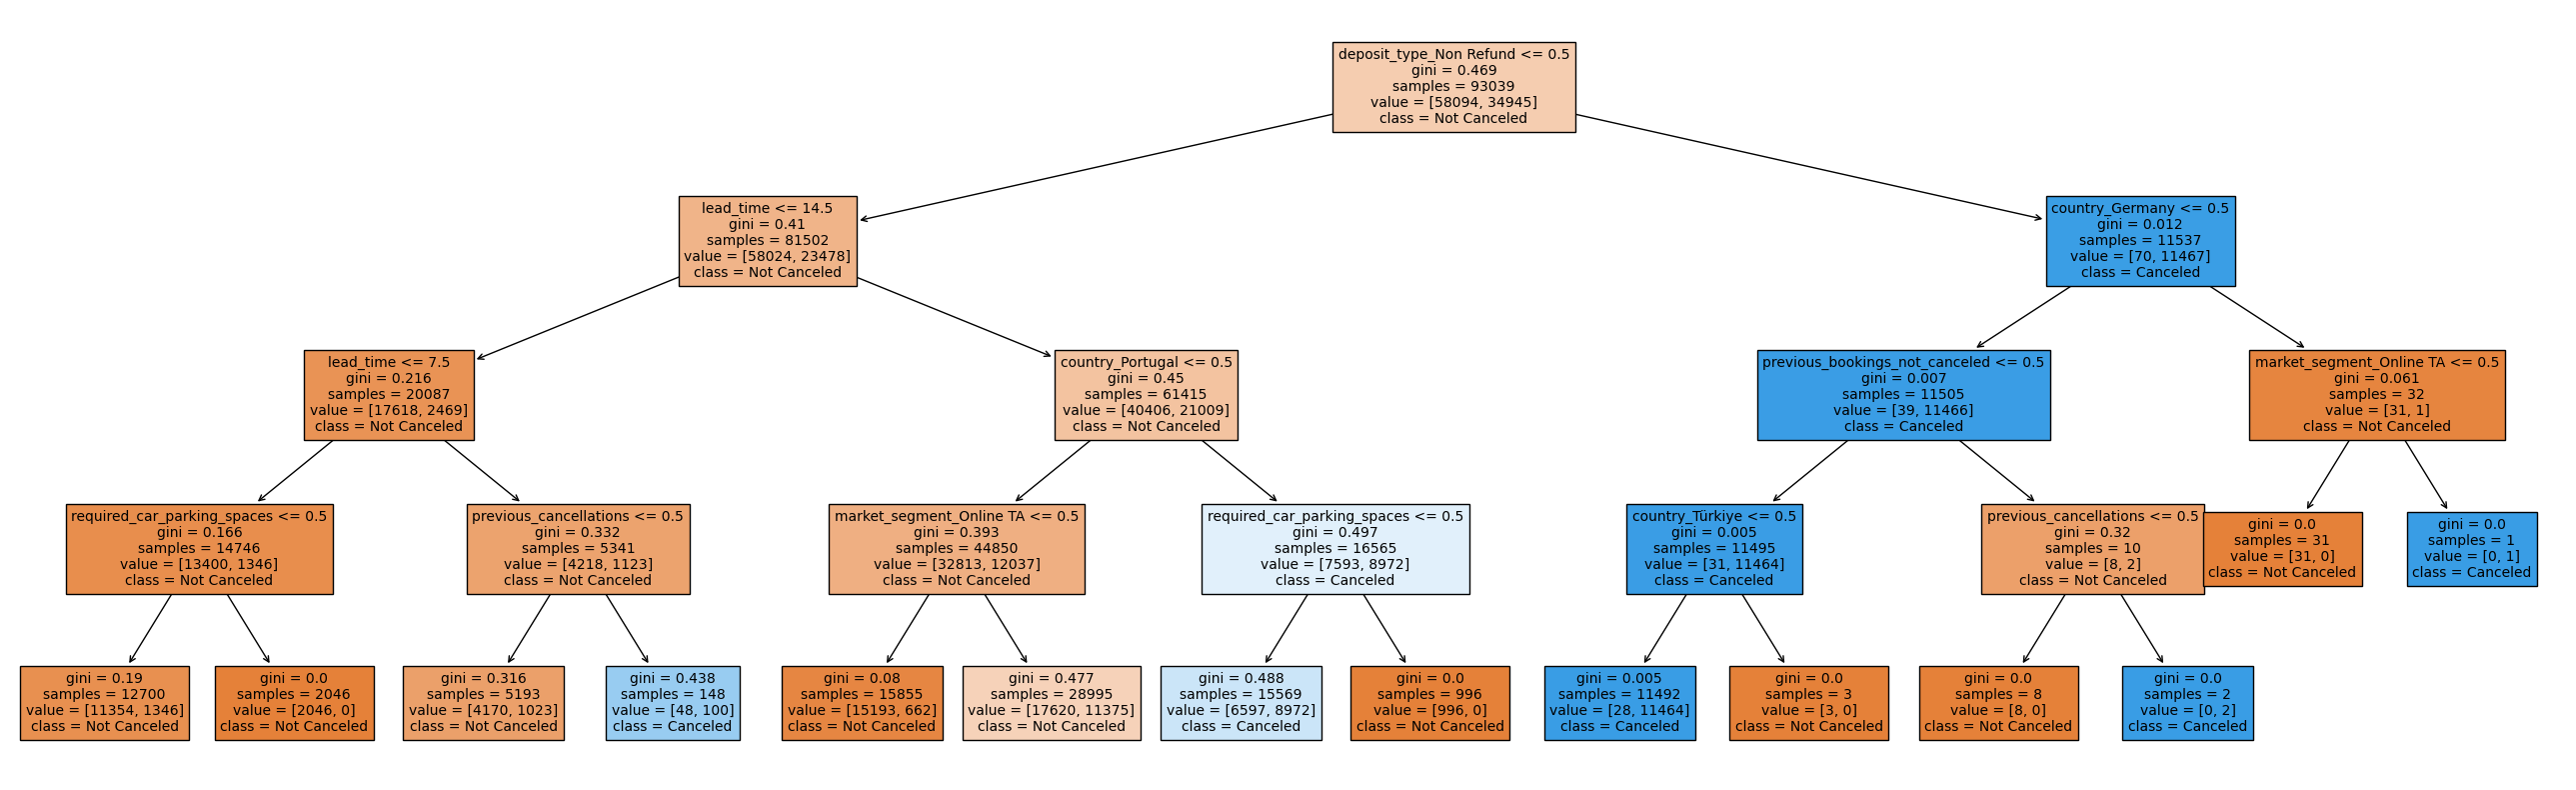

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Step 8: Plot the decision tree
plt.figure(figsize=(33, 10))
feature_names = list(X.columns)

plot_tree(
    dt_classifier,
    class_names=["Not Canceled", "Canceled"],
    feature_names=feature_names,
    filled=True, 
    fontsize=10
)
plt.show()

The tree has a depth of 4 and 14 leaves, which means it has 4 levels of splits and 14 terminal nodes where final predictions are made.

The tree uses features like deposit_type_Non Refund, lead_time, required_car_parking_spaces, previous_cancellations, country, and market_segment to make decisions. Here’s a breakdown:

Branch 1: deposit_type_Non Refund <= 0.50

This branch handles bookings without a non-refundable deposit.

1. If lead_time <= 14.50:
    - Short lead times are further split based on:
        - lead_time <= 7.50:
            - If required_car_parking_spaces <= 0.50, classify as not canceled (class: 0).
            - Otherwise, still classify as not canceled (class: 0).
        - lead_time > 7.50:
            - If previous_cancellations <= 0.50, classify as not canceled (class: 0).
            - Otherwise, classify as canceled (class: 1).
2. If lead_time > 14.50:
    - Bookings with longer lead times are split by:
        - country_Portugal <= 0.50 (booking is not from Portugal):
            - If market_segment_Online TA <= 0.50, classify as not canceled (class: 0).
            - Otherwise, classify as not canceled (class: 0).
        - country_Portugal > 0.50 (booking is from Portugal):
            - If required_car_parking_spaces <= 0.50, classify as canceled (class: 1).
            - Otherwise, classify as not canceled (class: 0).

Branch 2: deposit_type_Non Refund > 0.50

This branch handles bookings with a non-refundable deposit.

1. If country_Germany <= 0.50:
    - If previous_bookings_not_canceled <= 0.50:
        - If country_Türkiye <= 0.50, classify as canceled (class: 1).
        - Otherwise, classify as not canceled (class: 0).
    - If previous_bookings_not_canceled > 0.50:
        - If previous_cancellations <= 0.50, classify as not canceled (class: 0).
        - Otherwise, classify as canceled (class: 1).
2. If country_Germany > 0.50:
    - If market_segment_Online TA <= 0.50, classify as not canceled (class: 0).
    - Otherwise, classify as canceled (class: 1).

Key Insights:

Dominant Features:
- deposit_type_Non Refund: The first split indicates that whether a booking has a non-refundable deposit is the most important factor for predicting cancellations.
- lead_time: Shorter lead times (e.g., ≤ 14.50 days) generally correlate with non-cancellation.
- country and market_segment: These features play a role in further refining the prediction.

Patterns:
- Bookings with non-refundable deposits are more likely to be canceled if they originate from certain countries like Turkey or have previous cancellations.
- Short lead times (≤ 7.50 days) generally indicate a lower likelihood of cancellation.
- Guests from Portugal with no required parking spaces have a higher chance of canceling.

Limitations:
- The tree is highly dependent on categorical splits (e.g., country_Portugal, market_segment_Online TA), which may make it sensitive to class imbalances in these features.

Accuracy: 0.7742906276870163


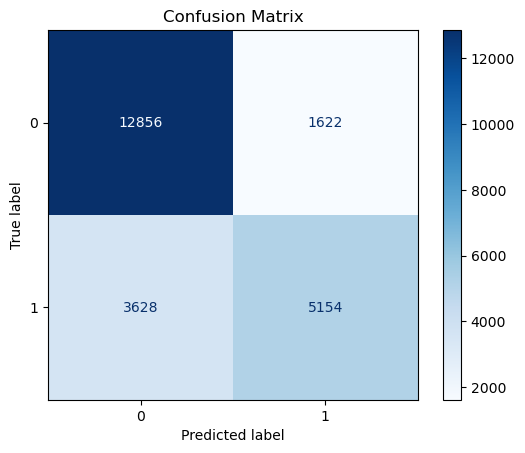

In [ ]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# predictions
y_pred = dt_classifier.predict(X_test)

# accuracy report
print("Accuracy:", accuracy_score(y_test, y_pred))

# confusion matrix
ConfusionMatrixDisplay.from_estimator(dt_classifier, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### Accuracy: 0.7743 (or about 77.43%)

This means that the decision tree correctly predicted the cancellation status for approximately 77.43% of the test data. While this is a decent performance, accuracy alone does not always provide the full picture, especially when dealing with imbalanced datasets.

### Confusion Matrix

- True Negatives (12856):
The model correctly identified 12856 bookings as "Not Canceled."

- False Positives (1622):
The model incorrectly classified 1622 bookings as "Canceled" when they were actually "Not Canceled."

-  False Negatives (3628):
The model incorrectly classified 3628 bookings as "Not Canceled" when they were actually "Canceled."

-  True Positives (5154):
The model correctly identified 5154 bookings as "Canceled."

### Precision for 'Canceled' class:

- Precision = TP / (TP + FP) = 0.76: 
Precision measures how many of the predicted "Canceled" bookings were actually canceled. A precision of 76% indicates relativel few false positives.

- Recall = TP / (TP + FN) = 0.59: 
Recall measures how many of the actual "Canceled" bookings were correctly idenified. A recall of 59% suggests the model misses some cancellations (false negative).

### Observations:

- High Accuracy but Low Recall:
The overall accuracy of 77.43% is solid, but the relatively low recall for the "Canceled" class (59%) indicates the model is missing many actual cancellations.

- Class Imbalance Effect:
If the dataset has more "Not Canceled" bookings than "Canceled" ones (as suggested by the higher number of true negatives), accuracy might be inflated. This is because the model can achieve high accuracy by predicting the majority class more frequently.

### Suggestions:
- Improving Recall for Cancellations:
Adjust the decision threshold to favor detecting more cancellations at the cost of potentially increasing false positives. Use techniques like oversampling or class weighting to handle any class imbalance.

- Alternative Models:
Try other classifiers like Random Forests, Gradient Boosting, or Logistic Regression, which may better balance precision and recall.